# Boosting and Stacking

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [2]:
from __future__ import print_function
import os
data_path = ['data']



* Importing the data from the file `Human_Activity_Recognition_Using_Smartphones_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
* Determining if the float columns need to be scaled.

In [3]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

In [4]:
data.shape

(10299, 562)

In [5]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [6]:
# masking to select float columns
float_columns=(data.dtypes==np.float)

# Verifying that the maximum of all float columns is 1.0
print((data.loc[:,float_columns].max()==1.0).all())

# Verifying that the minimum of all float columns is -1.0
print((data.loc[1,float_columns].min()==-1.0).all())


True
True


C:\Users\asus\AppData\Local\Temp\ipykernel_27660\3151981502.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  float_columns=(data.dtypes==np.float)




* Integer encode the activities.
* Spliting the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.

In [7]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

data['Activity']=le.fit_transform(data['Activity'])

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [8]:
data.Activity.unique()

array([2, 1, 0, 3, 4, 5])

In [9]:
from sklearn.model_selection import train_test_split

# stratifying the categories in the split

feature_columns=[x for x in data.columns if x != 'Activity']

X_train,X_test, y_train, y_test= train_test_split(data[feature_columns], data['Activity'],
                                                 test_size=0.3, random_state=42)



In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7209, 561), (7209,), (3090, 561), (3090,))



* Gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Ploting the accuracy as a function of estimator number.

**Note:** It may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence 


In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list=list()

# iterating through all of the possibilities for number of estimators
tree_list=[15,50,100,200,400]
for n_trees in tree_list:
    
    # initializing the gradient boost classifier
    GBC =GradientBoostingClassifier(n_estimators=n_trees,
                                   subsample=0.5,
                                   max_features=4,random_state=42)
    # fitting the model
    GBC.fit(X_train.values,y_train.values)
    y_pred=GBC.predict(X_test)
    
    # Get the error
    error=1.-accuracy_score(y_test,y_pred)
    
    #store it
    error_list.append(pd.Series({'n_trees':n_trees, 'error':error}))

error_df=pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


,error
n_trees,
15.0,0.106472
50.0,0.045307
100.0,0.026537
200.0,0.018447
400.0,0.014239


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

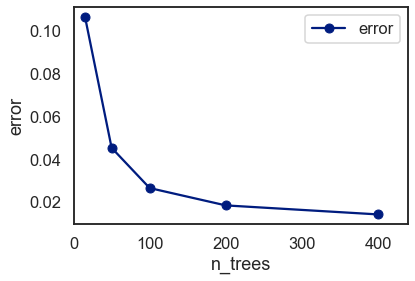

In [13]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

# create the plot
ax=error_df.plot(marker='o')

# set parameters
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0,max(error_df.index)*1.1);



* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 3. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [23]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit--only n_estimators and learning rate
# have been varied here for simplicity
param_grid = {'n_estimators': [200, 400],
              'learning_rate': [0.1, 0.01]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(subsample=0.5,
                                                 max_features=4,
                                                 random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [24]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=42,
                           subsample=0.5)

In [25]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.96      0.97      0.97       558
           2       0.97      0.97      0.97       549
           3       1.00      1.00      1.00       540
           4       0.99      1.00      0.99       419
           5       0.99      0.99      0.99       427

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



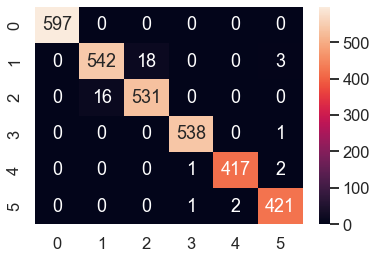

In [26]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')



* Creating an AdaBoost model and fit it using grid search, much like question 4. Try a range of estimators between 100 and 200.
* Comparing the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [28]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_features=4),
                   learning_rate=0.001, n_estimators=200)

In [29]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       582
           1       0.66      0.67      0.66       557
           2       0.69      0.67      0.68       565
           3       0.84      0.86      0.85       524
           4       0.80      0.79      0.79       426
           5       0.80      0.78      0.79       436

    accuracy                           0.76      3090
   macro avg       0.76      0.76      0.76      3090
weighted avg       0.76      0.76      0.76      3090



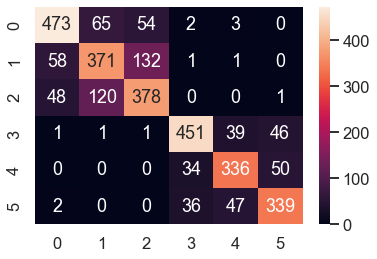

In [30]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')



* Fiting a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 4.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 4 and 5.
* Determining the error as before and compare the results to the appropriate gradient boosted model(s).
* Ploting the confusion matrix for the best model created in this set of exercises.

In [31]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(Cs=5, cv=4, penalty='l2').fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [32]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       602
           1       0.94      0.96      0.95       555
           2       0.95      0.96      0.96       546
           3       1.00      0.99      1.00       540
           4       0.99      1.00      0.99       417
           5       1.00      0.98      0.99       430

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



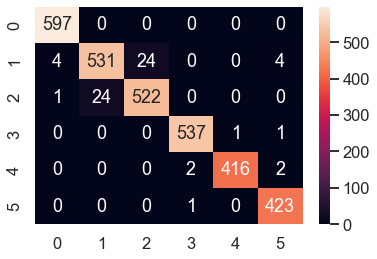

In [33]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

In [34]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [35]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.96      0.96       563
           2       0.97      0.96      0.97       547
           3       1.00      1.00      1.00       539
           4       1.00      1.00      1.00       420
           5       0.99      1.00      0.99       424

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



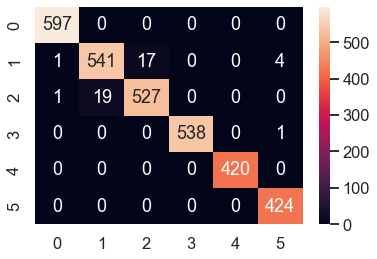

In [36]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')